<a href="https://colab.research.google.com/github/HumaSatti/Depression-Detection-By-ML-Deep-Learning-Model/blob/main/Nurse_prediction_deep_leraning_model_small_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nurse-stress-prediction-wearable-sensors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4110234%2F7125235%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240723%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240723T152520Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7a1682fedec17fdcb248941e43eadad3a320a75b946835e35182253cd550fe14f4e9806eb6d7c26443b83098e737c1cef34bac8343bed5c8c56c95d7f8926eaf7121c33744fc233007fdbbd8bfe4657dc5b5b749cb1dc04f1350bbc4f6cc9f06e693b135ce5c69babd52b8a8255ae36622deaeb644732b1a98f46d3e3cd7a4b75fc930fa9d824b2ce188466fd2f21e5b8f30f9d766a76b32bbc646cf2b0b0126bbd8fa7c7806a5d5b4fd648159284eba689b3d82e1097c29e169d209ab5b875e5b910d8fda5852b84509b3994ba6ea807069f939a83205a58f4c38308e261755225283659ccd76f7c921d8587af70f5964a55a678a26acd8c30fd1498c36dade'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79877492 bytes downloaded
Downloaded and uncompressed: nurse-stress-prediction-wearable-sensors
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

In [4]:
# Load the dataset
df = pd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv', low_memory=False, parse_dates=['datetime'])
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   X         float64       
 1   Y         float64       
 2   Z         float64       
 3   EDA       float64       
 4   HR        float64       
 5   TEMP      float64       
 6   id        object        
 7   datetime  datetime64[ns]
 8   label     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 790.3+ MB


In [6]:
df.head(8)

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
5,-9.0,-57.0,-32.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.156250112,2.0
6,9.0,-68.0,-2.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.187500032,2.0
7,-6.0,-74.0,17.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.218749952,2.0


In [7]:
df.datetime

0          2020-07-08 14:03:00.000000000
1          2020-07-08 14:03:00.031249920
2          2020-07-08 14:03:00.062500096
3          2020-07-08 14:03:00.093750016
4          2020-07-08 14:03:00.124999936
                        ...             
11509046   2020-07-23 17:28:59.875000064
11509047   2020-07-23 17:28:59.906249984
11509048   2020-07-23 17:28:59.937499904
11509049   2020-07-23 17:28:59.968750080
11509050   2020-07-23 17:29:00.000000000
Name: datetime, Length: 11509051, dtype: datetime64[ns]

In [8]:
#df.isna().sum()
print(df.isna().sum())

X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64


In [9]:
df.nunique()

X                256
Y                256
Z                256
EDA           274452
HR              6268
TEMP             599
id                15
datetime    10628304
label              3
dtype: int64

In [10]:
# Extract datetime features
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

In [11]:
# Drop unnecessary columns
df.drop(['datetime', 'id'], axis=1, inplace=True)

Exploratory Data Analysis

In [ ]:
sns.distplot(df['X'])

In [ ]:
sns.distplot(df['Y'])

In [ ]:
sns.distplot(df['EDA'])

In [ ]:
sns.distplot(df['HR'])

In [ ]:
sns.distplot(df['TEMP'])

In [ ]:
df['label'].value_counts()

In [ ]:
df['label'].value_counts().plot(kind='bar')
plt.title('Frequency of Each Category')
plt.ylabel('Frequency')

In [ ]:
# Correlation matrix
corr_mat = df.corr().round(2)
# Correlation matrix
corr_mat

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis Plot')
plt.show()

In [ ]:
corr_mat['label']

In [12]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

In [14]:
# Sample a subset of the data for initial training (e.g., 10% of the data)
sample_frac = 0.10
X_sampled, _, y_sampled, _ = train_test_split(X, y, test_size=1-sample_frac, stratify=y, random_state=42)


In [15]:
# Handle imbalanced data
over_sample = RandomOverSampler(random_state=42)
X_sampled, y_sampled = over_sample.fit_resample(X_sampled, y_sampled)


In [16]:
# Split the sampled dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [17]:
# Scale the features
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [18]:
# Set up the strategy for TPU/CPU/GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU and GPU


In [19]:
# Build the model inside the strategy scope
with strategy.scope():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')  # Adjust the output layer according to your number of classes
    ])


In [20]:
 model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')


In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])


Epoch 1/50
64055/64055 [==============================] - 205s 3ms/step - loss: 0.1793 - accuracy: 0.9297 - val_loss: 0.0444 - val_accuracy: 0.9846
Epoch 2/50
64055/64055 [==============================] - 205s 3ms/step - loss: 0.1040 - accuracy: 0.9627 - val_loss: 0.0263 - val_accuracy: 0.9930
Epoch 3/50
64055/64055 [==============================] - 196s 3ms/step - loss: 0.0906 - accuracy: 0.9683 - val_loss: 0.0234 - val_accuracy: 0.9935
Epoch 4/50
64055/64055 [==============================] - 189s 3ms/step - loss: 0.0831 - accuracy: 0.9713 - val_loss: 0.0210 - val_accuracy: 0.9937
Epoch 5/50
64055/64055 [==============================] - 195s 3ms/step - loss: 0.0789 - accuracy: 0.9730 - val_loss: 0.0223 - val_accuracy: 0.9945
Epoch 6/50
64055/64055 [==============================] - 207s 3ms/step - loss: 0.0755 - accuracy: 0.9744 - val_loss: 0.0189 - val_accuracy: 0.9948
Epoch 7/50
64055/64055 [==============================] - 193s 3ms/step - loss: 0.0732 - accuracy: 0.9752 - val_

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


8007/8007 [==============================] - 14s 2ms/step - loss: 0.0094 - accuracy: 0.9976
Test Loss: 0.009404374286532402, Test Accuracy: 0.9976075291633606


In [24]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


8007/8007 [==============================] - 78s 10ms/step


In [25]:
y_pred

array([[1.71889624e-04, 9.99285221e-01, 5.43007918e-04],
       [1.55377295e-03, 4.30515151e-10, 9.98446226e-01],
       [5.39716384e-05, 9.99380529e-01, 5.65588009e-04],
       ...,
       [6.31964474e-04, 4.82225696e-05, 9.99319732e-01],
       [1.48582915e-08, 3.89153363e-14, 1.00000000e+00],
       [8.33394733e-05, 9.99312997e-01, 6.03562046e-04]], dtype=float32)

In [26]:
y_pred_classes

array([1, 2, 1, ..., 2, 2, 1])

In [27]:
# Classification report
print(classification_report(y_test, y_pred_classes))


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     85415
         1.0       1.00      1.00      1.00     85576
         2.0       1.00      1.00      1.00     85227

    accuracy                           1.00    256218
   macro avg       1.00      1.00      1.00    256218
weighted avg       1.00      1.00      1.00    256218



In [28]:
print('Classification Report:')
print(classification_report)

Classification Report:
<function classification_report at 0x7f9308e73250>


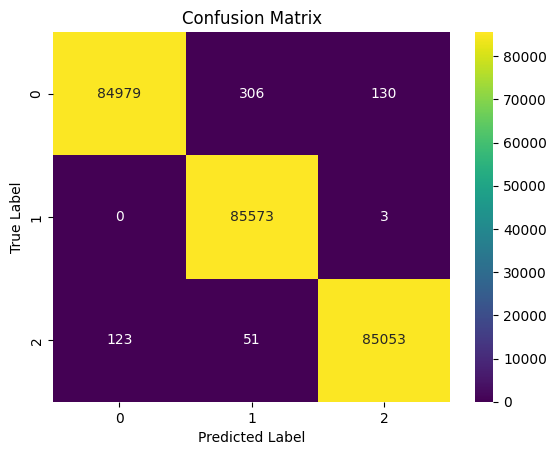

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[84979   306   130]
 [    0 85573     3]
 [  123    51 85053]]


In [31]:
print("Deep Learning Model Performance:")
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

Deep Learning Model Performance:
[[84979   306   130]
 [    0 85573     3]
 [  123    51 85053]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     85415
         1.0       1.00      1.00      1.00     85576
         2.0       1.00      1.00      1.00     85227

    accuracy                           1.00    256218
   macro avg       1.00      1.00      1.00    256218
weighted avg       1.00      1.00      1.00    256218



In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 12099 (47.26 KB)
Trainable params: 12099 (

In [33]:
model.get_weights()

[array([[-0.07102413, -0.08736835,  0.11427929, ...,  0.00687348,
          0.01797252, -0.17942175],
        [-0.04622963, -0.01970063,  0.03334082, ...,  0.01967658,
         -0.11916862,  0.06595295],
        [ 0.23437952, -0.00397087, -0.05751855, ...,  0.0260252 ,
          0.00733359,  0.3089798 ],
        ...,
        [ 0.28937986, -0.25230548, -0.05588316, ...,  0.01884233,
         -0.32889152,  0.12619215],
        [-0.05711861,  0.03200463, -0.07017989, ...,  0.09702907,
          0.012196  ,  0.01198672],
        [ 0.09765177, -0.74544376,  1.6531724 , ..., -1.0575583 ,
         -0.01946032,  1.1585402 ]], dtype=float32),
 array([-2.9583418 , -2.0932643 , -0.8176824 , -1.3227649 , -2.6334753 ,
        -1.477277  , -1.1660678 ,  0.0254626 , -2.9658391 , -3.007182  ,
        -4.4598794 , -2.202314  , -2.5789237 , -0.77865165, -2.6204994 ,
        -1.0270685 , -1.8136709 , -1.5902754 , -1.4611695 , -0.9235129 ,
        -2.147957  , -1.6105654 , -2.5508957 , -0.5192915 , -2.100

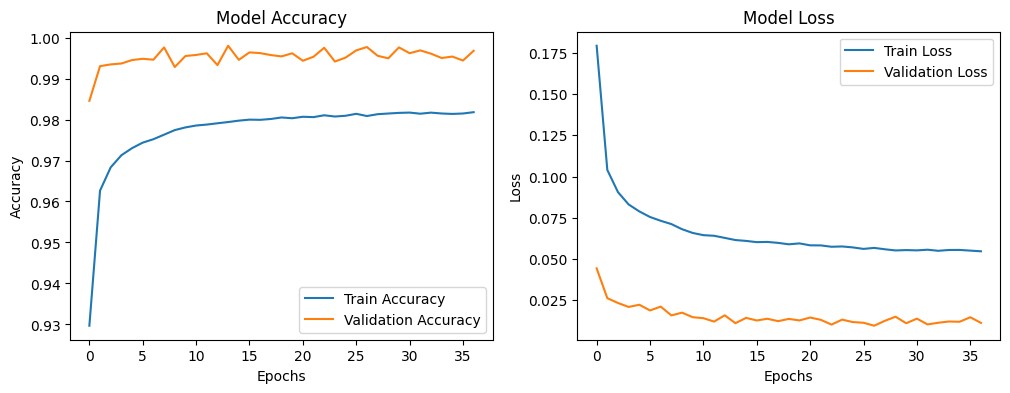

In [34]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch	Train Accuracy	Validation Accuracy
1	0.9297		0.9846
2	0.9627		0.9930
3	0.9683		0.9935
4	0.9713		0.9937
5	0.9730		0.9945
6	0.9744		0.9948
7	0.9752		0.9946
8	0.9763		0.9976
9	0.9774		0.9928
10	0.9781		0.9955
11	0.9785		0.9958
12	0.9788		0.9962
13	0.9791		0.9933
14	0.9794		0.9980
15	0.9797		0.9946
16	0.9800		0.9964
17	0.9799		0.9962
18	0.9801		0.9957
19	0.9805		0.9954
20	0.9803		0.9962
21	0.9807		0.9943
22	0.9806		0.9953
23	0.9810		0.9975
24	0.9807		0.9941
25	0.9809		0.9951
26	0.9814		0.9969
27	0.9809		0.9977
28	0.9813		0.9956
29	0.9815		0.9949
30	0.9816		0.9976
31	0.9817		0.9962
32	0.9814		0.9969
33	0.9817		0.9961
34	0.9815		0.9950
35	0.9814		0.9954
36	0.9815		0.9944
37	0.9818		0.9968


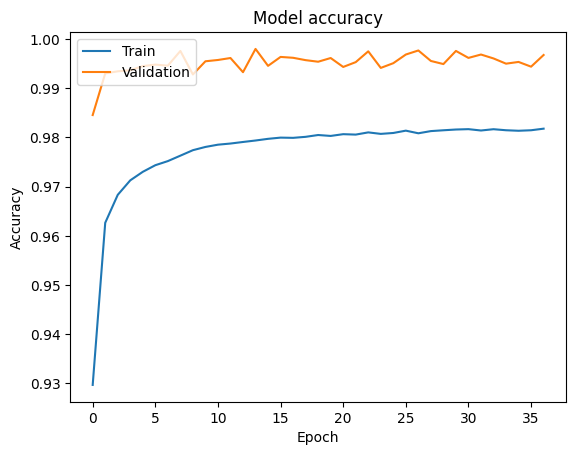

In [35]:
# Extract training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Print the accuracy values
print("Epoch\tTrain Accuracy\tValidation Accuracy")
for epoch in range(len(train_accuracy)):
    print(f"{epoch+1}\t{train_accuracy[epoch]:.4f}\t\t{val_accuracy[epoch]:.4f}")

# Optional: Visualize the training history
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
model.save('final_model.keras')

In [37]:
import json

history_dict = history.history
with open('history.json', 'w') as f:
    json.dump(history_dict, f)